In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/Shareddrives/Image_Captioning/8k_image_captioning.zip'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2 as op
import progressbar
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, add, Conv2D
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import seaborn as sea
from scipy import stats
from keras import layers
from os import listdir
from keras.applications.vgg16 import preprocess_input
from pickle import dump, load
from sklearn.model_selection import KFold
from tqdm import tqdm

plt.style.use('seaborn')
tf.__version__

'2.7.0'

In [ ]:
df = pd.read_csv("/content/captions.txt")

In [ ]:
df.describe()

,image,caption
count,40455,40455
unique,8091,40201
top,3582685410_05315a15b8.jpg,Two dogs playing in the snow .
freq,5,7


In [ ]:
n_images = 8091
n_captions = 40455
8091 * 5 == 40455

True

In [ ]:
def get_mobileNet():
    base_model = MobileNet(input_shape = (224,224,3), include_top = True)
#     x = Conv2D(filters = 512, kernel_size = (1,1), activation = 'sigmoid')(base_model.layers[-5].output)
    base_model = Model(inputs= base_model.inputs, outputs= base_model.layers[-5].output)
    base_model.training = False
    return base_model

def get_vgg16():
    base_model = VGG16(input_shape = (224,224,3), weights = 'imagenet', include_top = True)
    base_model = Model(inputs = base_model.inputs, outputs = base_model.layers[-6].output)
    base_model.training = False
    return base_model

def get_InceptionNet():
    base_model = InceptionV3(input_shape = (229, 229, 3), weights = 'imagenet', include_top = False)
    base_model = Model(inputs = base_model.inputs, outputs = base_model.layers[-2].output)
    base_model.training = False
    return base_model

In [ ]:
base_model = get_mobileNet()
base_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128    

In [ ]:
def load_preprocess_image(path):
    img = op.imread(path)
    img = op.cvtColor(img, op.COLOR_BGR2RGB)
    img = op.resize(img, (224,224))
    img = img/255.0
    img = img.reshape(1,224,224,3)
    return img


In [ ]:
img = load_preprocess_image('/content/Images/102351840_323e3de834.jpg')
plt.imshow(img[0])

NameError: ignored

In [ ]:
def extract_features(directory):
    
    features = dict()
    
    for i, name in enumerate(listdir(directory)):
        img = load_preprocess_image(directory + "/" + name)
        fvec = base_model.predict(img, verbose = 0)
        features[name] = fvec

        if((i+1) % 1000 == 0):
            print((i+1),'Done')
    
    return features

In [ ]:
#There is no need to run this and the cell after this as pkl file is there in the shared drive
DIR = '/content/Images'

features = extract_features(DIR)

In [ ]:
dump(features, open('features.pkl', 'wb'))
del features

In [ ]:
import string

def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

def lower_text(text):
    return str(text).lower()

def add_start_end(caption):
    caps = []
    for cap in caption:
        cap = 'startseq' + cap + ' endseq'
        caps.append(cap)
    return caps

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_numeric(text)
    text = lower_text(text)
    return(text)

with progressbar.ProgressBar(max_value=len(df.caption.values)) as bar:
    for i, caption in enumerate(df.caption.values):
        newcaption = text_clean(caption)
        df["caption"].iloc[i] = newcaption
        bar.update(i)

100% (40455 of 40455) |##################| Elapsed Time: 0:00:15 Time:  0:00:15


In [ ]:
df['caption'] = add_start_end(df['caption'])

In [ ]:
df['caption'].values

array(['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
       'startseq a girl going into a wooden building endseq',
       'startseq a little girl climbing into a wooden playhouse endseq',
       ...,
       'startseq a person in a red shirt climbing up a rock face covered in assist handles endseq',
       'startseq a rock climber in a red shirt endseq',
       'startseq a rock climber practices on a rock climbing wall endseq'],
      dtype=object)

In [ ]:
def get_vocab_len():
    vocabulary = []

    for i in range(len(df)):
        try:
            temp = df.iloc[i,1]
            vocabulary.extend(temp.split())
        except:
            print(i)

    return len(set(vocabulary))

In [ ]:
n_vocab = get_vocab_len()
n_vocab += 1
print(n_vocab)

8778


In [ ]:
tokenizer = Tokenizer(n_vocab)

tokenizer.fit_on_texts(df['caption'].values)

# tokenized_captions = tokenizer.texts_to_sequences(df['caption'].values)

In [ ]:
word2idx = tokenizer.word_index
word2idx['pad'] = 0
idx2word = dict((idx, word) for (word, idx) in word2idx.items())

def decode(seq):
    return " ".join([idx2word.get(idx, "?") for idx in seq])

In [ ]:

all_features = load(open('/content/drive/Shareddrives/Image_Captioning/features.pkl', 'rb'))
for key in all_features.keys():
    all_features[key] = np.reshape(all_features[key], (1024, ))
    
PATH = '/content/Images'

def create_sequences(captions, images, seq_len = 6):
    X1, X2, y = [], [], []

    for cap, img in zip(captions, images):
        cap = cap.split()
        # predicting each next word
        # earlier window was selected and then next word was predicted
        # problem observed was initial words were not predicted during testing, since they weren't predicted during training itself
        for i in range(0, len(cap)-1):
            in_seq = tokenizer.texts_to_sequences([cap[0 : i + 1]])
            in_seq = pad_sequences(in_seq, maxlen = seq_len, padding = 'post')[0]
            out_seq = word2idx[cap[i + 1]]
            
            if(sum(in_seq) == 0):
                break
            
            X1.append(in_seq)
            X2.append(all_features[img])
            y.append(np_utils.to_categorical(out_seq, n_vocab))
    
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
class MyModel(keras.Model):
    
    def __init__(self, units, embedding_dim, seq_len, n_vocab):
        super(MyModel, self).__init__()
        self.fc1 = Dense(256, activation = 'relu')
        self.fc2 = Dense(units * 2, activation = 'relu', kernel_regularizer = keras.regularizers.L2(0.01))
        self.fc3 = Dense(n_vocab, activation = 'softmax')
        self.Embedding = Embedding(n_vocab, embedding_dim, mask_zero = True)
        self.LSTM1 = LSTM(256, return_sequences = True, kernel_regularizer = keras.regularizers.L2(0.03))
        self.LSTM2 = LSTM(units, kernel_regularizer = keras.regularizers.L2(0.01))
        self.dropout = Dropout(0.4)
        self.repeat = keras.layers.RepeatVector(6)
        
    def call(self, features, sequence):   # features = (bs, 1024), sequence = (bs, 6) 

        features = self.fc1(features)   # features = (bs, 256)
        
        sequence = self.Embedding(sequence) # sequence = (bs, 6, 128)
        sequence = tf.concat([self.repeat(features), sequence], axis = -1) # sequence = (bs, 6, 384) 
        sequence = self.LSTM1(sequence)  # sequence = (bs, 6, 256)
        sequence = self.dropout(sequence)
        sequence = self.LSTM2(sequence) # sequence = (bs, 512)
        
        sequence = tf.concat([features, sequence], axis = -1)  # sequence = (bs, 768)
        sequence = self.dropout(sequence)
        sequence = self.fc2(sequence)   # sequence = (bs, 1024)
        sequence = self.dropout(sequence) 
        
        out = self.fc3(sequence)   #sequence = (bs, n_vocab)
        
        return out

In [ ]:
embedding_dim = 256
seq_len = 6
units = 512

model = MyModel(units, embedding_dim, seq_len, n_vocab)
# model.summary()

In [ ]:
# keras.utils.plot_model(model, show_shapes =True)

In [ ]:
loss, val = [], []

In [ ]:
def data_generator(data, batch_size):
    td = data.sample(n = batch_size)
    x1, x2, y = create_sequences(td.iloc[:, 1], td.iloc[:, 0], seq_len)
    return [x2, x1, y]

In [ ]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.CategoricalCrossentropy()

def cal_loss(y, y_pred):
    loss = loss_object(y, y_pred)
    return tf.reduce_mean(loss)


In [ ]:
@tf.function
def train_step(features, seqs, y):
    
    with tf.GradientTape() as tape:
        pred = model(features, seqs)
        loss = cal_loss(y, pred)
        
        trainable_vars = model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        optimizer.apply_gradients(zip(gradients, trainable_vars))
  
    return loss

In [ ]:
def val_step(features, seqs, y):
    pred = model(features, seqs)
    loss = cal_loss(y, pred)
    return loss

In [ ]:
epochs = 5
batch_size = 32

kf = KFold(n_splits = 5)

for i in range(epochs):
    print("Epoch:", i+1)
    train_loss, test_loss = 0,0
    
    train_idx, test_idx = next(kf.split(df))
    df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]
    
    train_n_steps = len(df_train)//batch_size
    val_n_steps = len(df_test)//batch_size
    
    for _ in tqdm(range(train_n_steps)):
        x1, x2, y = data_generator(df_train, batch_size)
        train_loss += train_step(x1, x2, y)
    
    for _ in range(val_n_steps):
        x1, x2, y = data_generator(df_test, batch_size)
        test_loss += val_step(x1,x2,y)
        
    test_loss = test_loss / val_n_steps    
    train_loss = train_loss / train_n_steps
    
    loss.append(train_loss)
    val.append(test_loss)
    
    print("Train Loss: {}, Test Loss: {}".format(train_loss, test_loss))
    

Epoch: 1


  0%|          | 4/1011 [00:06<27:07,  1.62s/it]

  1%|          | 6/1011 [00:08<19:14,  1.15s/it]

100%|██████████| 1011/1011 [03:11<00:00,  5.28it/s]


Train Loss: 3.8778650760650635, Test Loss: 3.4540812969207764
Epoch: 2


100%|██████████| 1011/1011 [00:56<00:00, 17.84it/s]


Train Loss: 2.825653553009033, Test Loss: 3.3445894718170166
Epoch: 3


100%|██████████| 1011/1011 [00:43<00:00, 23.48it/s]


Train Loss: 2.3935811519622803, Test Loss: 3.4294772148132324
Epoch: 4


100%|██████████| 1011/1011 [00:43<00:00, 23.21it/s]


Train Loss: 2.075169801712036, Test Loss: 3.597977876663208
Epoch: 5


100%|██████████| 1011/1011 [00:40<00:00, 24.78it/s]


Train Loss: 1.808955192565918, Test Loss: 3.767366886138916


In [ ]:
optimizer.lr.assign(optimizer.lr/2)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.0005>

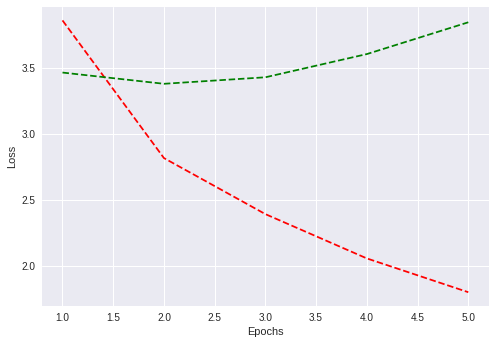

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(np.arange(len(loss))+ 1, loss, '--r')
plt.plot(np.arange(len(val)) + 1, val, '--g')
plt.show()

In [ ]:
# model.save('Dec30_loss=1.536.h5')

In [ ]:
def predict_caption(image):
    
    in_text = 'startseq'

    for iword in range(30):
        sequence = tokenizer.texts_to_sequences([in_text])
        sequence = pad_sequences(sequence, maxlen = seq_len, padding = 'post')[0]
        sequence = np.array(sequence).reshape(1, -1)
    
        yhat = model(image,sequence)
        yhat = np.argmax(yhat)
        
        newword = idx2word[yhat]
        # print(newword)
        in_text += " " + newword
        
        if newword == "endseq":
            break
            
    return(in_text)

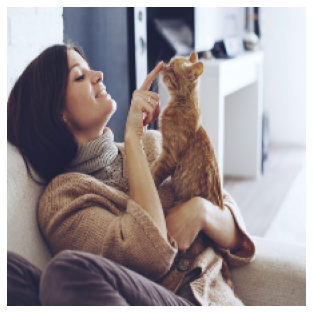

In [ ]:

# url = 'https://media.istockphoto.com/photos/group-of-young-people-taking-selfie-picture-id503139097'
url = 'https://i.insider.com/5afc93865e48ec51008b458a?width=600&format=jpeg&auto=webp'
# url = 'https://i0.wp.com/post.healthline.com/wp-content/uploads/2020/07/Woman-riding-bycicle-at-the-park-1296x728-header.jpg?w=1155&h=1528'
import requests, io
import numpy as np
from PIL import Image


response = requests.get(url)
bytes_im = io.BytesIO(response.content)
img = op.cvtColor(np.array(Image.open(bytes_im)), op.COLOR_BGR2RGB)

img = op.resize(img, (224,224))
img = op.cvtColor(img, op.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)
img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
img = img/255.0


In [ ]:
img_vec = base_model.predict(img).reshape(1,-1)

In [ ]:
img_vec.shape

(1, 1024)

In [ ]:
ans = predict_caption(img_vec)
ans

'startseq a woman wearing a pink dress endseq'

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate(df_valid):
    ac, pr = [],[]
    
    for img, cap in zip(df_valid['image'], df_valid['caption']):
        img = all_features[img].reshape(1, 1024)
        ans = predict_caption(img)
        ac.append(cap)
        pr.append(ans)
    
    pr = np.array(pr)
    ac = np.array([[i] for i in ac])
        
    print('BLEU-1: %f' % corpus_bleu(ac, pr, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(ac, pr, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(ac, pr, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(ac, pr, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
evaluate(df.sample(100))

BLEU-1: 0.656032
BLEU-2: 0.568057
BLEU-3: 0.520471
BLEU-4: 0.445510
